# Astronomical Object Classification

## Introduction  
This project applies supervised machine learning to classify astronomical objects into three categories: **galaxies, stars, and quasars (QSOs)**. The dataset is based on photometric and spectroscopic measurements.  

The workflow includes:  
- **Data exploration and cleaning**: handling missing values, removing extreme values (-9999), dropping irrelevant metadata features  
- **Exploratory Data Analysis (EDA)**: histograms, boxplots, redshift distributions, correlation analysis, and pairplots  
- **Feature selection and preprocessing**: standardization of numerical variables  
- **Model training and evaluation**: Support Vector Machines (SVC), Logistic Regression, Random Forest, and K-Nearest Neighbors (KNN)  
- **Hyperparameter tuning** with `RandomizedSearchCV` to optimize model performance  
- **Evaluation metrics**: accuracy, F1-score, confusion matrices, and classification reports  

## Assignment Description
You have been hired by Kongsberg Satellite Services (KSAT), a leading provider of ground station services and satellite-based Earth observation. KSAT is expanding its capabilities in deep-space monitoring and needs your expertise to classify celestial objects from telescope observations.

Your task is to develop an accurate model to classify Astronomical object—distinguishing between stars, galaxies, and quasars. Your work will help improve automated processing of astronomical data, allowing scientists to track cosmic phenomena more efficiently. The ability to classify these objects quickly and accurately is essential for optimizing satellite operations and supporting deep-space research.

KSAT has provided a dataset containing 100,000 observations of space, each recorded with multiple spectral and positional features. This data comes from advanced space monitoring systems and represents a crucial step in identifying and categorizing celestial objects.

## **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from scipy.stats import loguniform

In [2]:
# Set a Seaborn aesthetic
sns.set(style="darkgrid")

## **Reading data**

In [3]:
# Load training and test datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

## **Data exploration and visualisation**

### *Descriptive Statistics*

In [4]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (80000, 18)
Test shape: (20000, 17)


The traininig set consists of 80 000 rows and 18 columns, while the test set consists of 20 000 rows and 17 columns. 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       80000 non-null  float64
 1   alpha        80000 non-null  float64
 2   delta        80000 non-null  float64
 3   u            79638 non-null  float64
 4   g            80000 non-null  float64
 5   r            80000 non-null  float64
 6   i            80000 non-null  float64
 7   z            80000 non-null  float64
 8   run_ID       80000 non-null  int64  
 9   rerun_ID     80000 non-null  int64  
 10  cam_col      80000 non-null  int64  
 11  field_ID     80000 non-null  int64  
 12  spec_obj_ID  80000 non-null  float64
 13  class        80000 non-null  object 
 14  redshift     80000 non-null  float64
 15  plate        80000 non-null  int64  
 16  MJD          80000 non-null  int64  
 17  fiber_ID     80000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usa

There seems to be some missing values in the u-feature.

In [6]:
# Check missing values
train_df.isna().sum()

obj_ID           0
alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64

This confirms that there is 362 missing values in the u-feature, which needs to be taken into account.

In [7]:
# First five rows
train_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [8]:
# Statistics
train_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,8.000000e+04,80000.000000,80000.000000,79638.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000
mean,1.237665e+18,177.579220,24.132590,21.961115,20.507677,19.647426,19.085051,18.644640,4477.876713,301.0,3.511388,185.663050,5.783094e+18,0.577219,5136.309963,55587.191400,448.887437
std,8.424878e+12,96.409584,19.650113,35.581856,35.483302,1.855636,1.757630,35.462189,1961.579187,0.0,1.589033,148.433559,3.327780e+18,0.731597,2955.646539,1809.144282,272.328619
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995801e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.643892,5.170723,20.353990,18.963188,18.135523,17.732600,17.457503,3185.000000,301.0,2.000000,82.000000,2.841535e+18,0.055160,2523.750000,54233.000000,221.000000
50%,1.237663e+18,180.761747,23.603480,22.187965,21.101015,20.127550,19.405635,19.004420,4188.000000,301.0,4.000000,146.000000,5.606066e+18,0.425051,4979.000000,55868.000000,432.000000
75%,1.237668e+18,233.815698,39.904905,23.698457,22.125007,21.047242,20.401857,19.923013,5326.000000,301.0,5.000000,240.000000,8.331746e+18,0.704777,7400.000000,56777.000000,644.000000
max,1.237681e+18,359.999615,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


The u-, g-, and z-features has min. values of -9999, indicating extreme values or incorrect input, which we need investigate further.

### *Extreme values/incorrect input (-9999)*

In [9]:
# Investigate the -9999 values
ex_filters = ["u", "g", "z"]
for col in ex_filters:
    print(f"{col} has {(train_df[col] == -9999).sum()} extreme or incorrect values (-9999)")


u has 1 extreme or incorrect values (-9999)
g has 1 extreme or incorrect values (-9999)
z has 1 extreme or incorrect values (-9999)


We've choosen to deal with these values before proceeding with the visualizations, as they might make the plots weird or harder to read. Therefore, we make a copy of the original dataset which we'll proceed the rest of the EDA on. 

In [10]:
# Make a copy for EDA
eda_train = train_df.copy()

# Remove rows with -9999 values
for col in ex_filters:
    eda_train = eda_train[eda_train[col] != -9999]

### *Distribution of the target "Class"*

In [11]:
# Count the distribution of target variable
eda_train["class"].value_counts()

GALAXY    47585
STAR      17250
QSO       15164
Name: class, dtype: int64

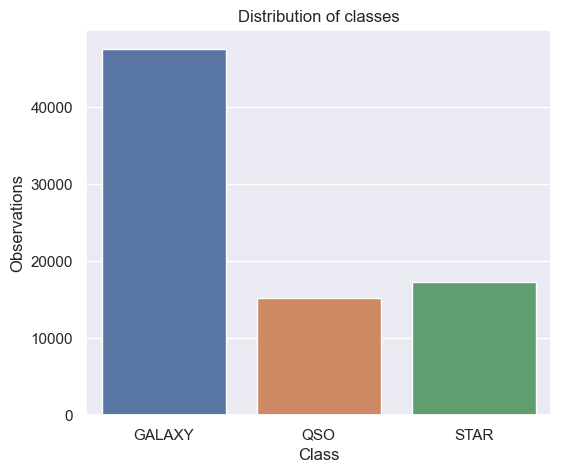

In [12]:
# Visualize the distribution of the target 
plt.figure(figsize=(6,5))
sns.countplot(x = "class", data = eda_train, hue= "class")
plt.title("Distribution of classes")
plt.xlabel("Class")
plt.ylabel("Observations")
plt.show()

GALAXY has 47 585 observations, which is approximately 59,5% of the overall dataset. Similarly QSO has 15 164 observations (18,9%) and STAR has 17 251 (21,6%.). GALAXY is clearly overrepresented, which indicates a imbalance in the dataset.

### *Histograms and boxplot of the filters*

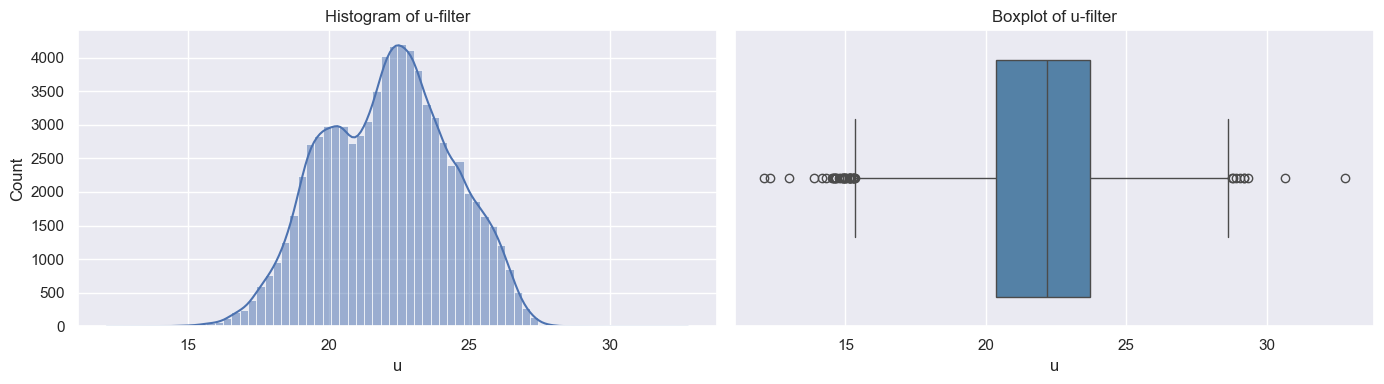

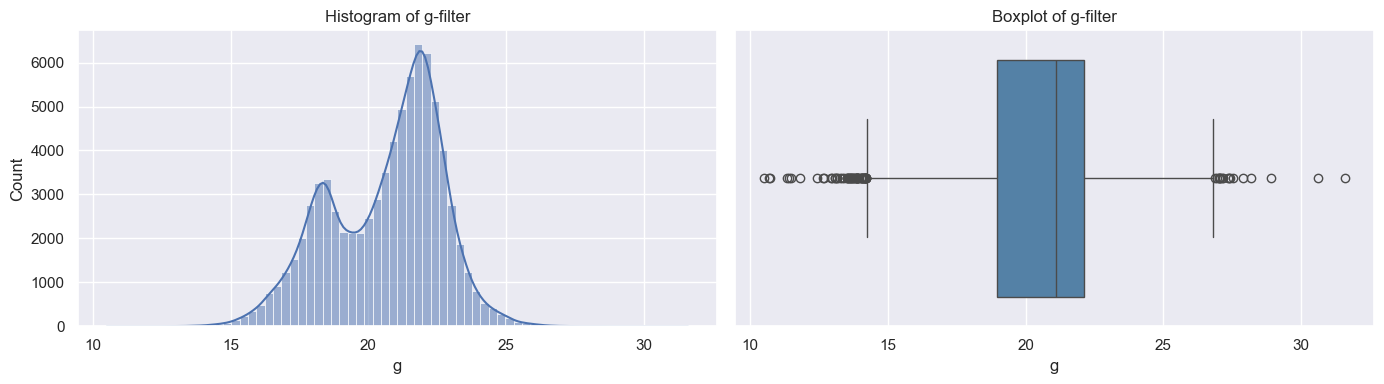

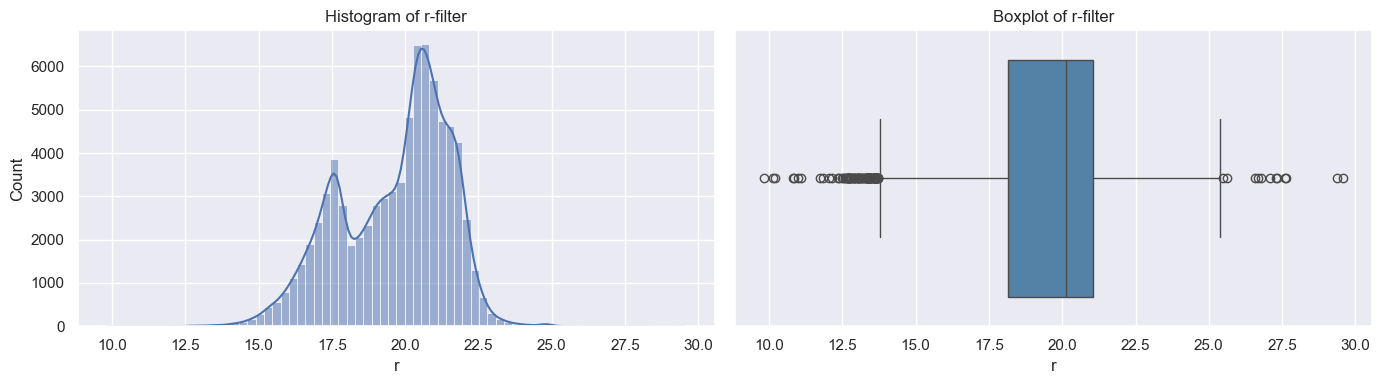

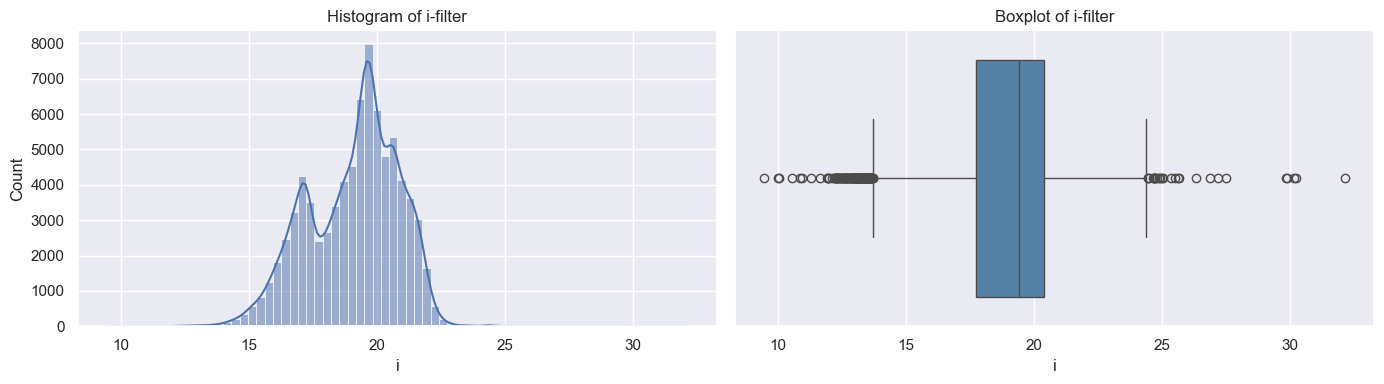

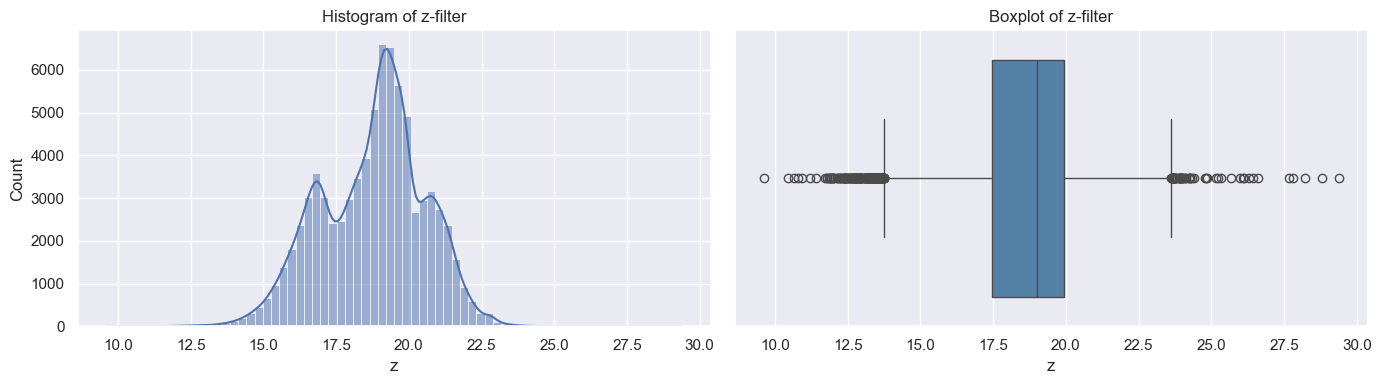

In [13]:
for col in ["u", "g", "r", "i", "z"]:
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    
    sns.histplot(data=eda_train, x=col, bins=70, kde=True, ax=axs[0])
    axs[0].set_title(f"Histogram of {col}-filter")

    sns.boxplot(x=eda_train[col], ax=axs[1], color="steelblue")
    axs[1].set_title(f"Boxplot of {col}-filter")

    plt.tight_layout()
    plt.show()

- **u-filter** shows a right skewed distribution, with a top between 20 and 25, approx. 22-23. There is some outliers both in the lower and higher ends of the boxplot. 
- **g-filter** has two tops, approximately around 18 and 22, indicating that there are separations of classes. There are a lot of outliers here as well. 
- **r-filter** also has two tops such as the g-filter. More outliers in the lower end than in the higher. 
- **i-filter** has a more dense distribution than g and r, but also with two tops. This also has a lot of outliers in both ends - seems to be the most in the lower end.
- **z-filter** similar to i and r, but seems to be three tops - with one main top. Also a lot of outliers - maybe also the most outliers of the filters. 


### *Distribution of redshift*

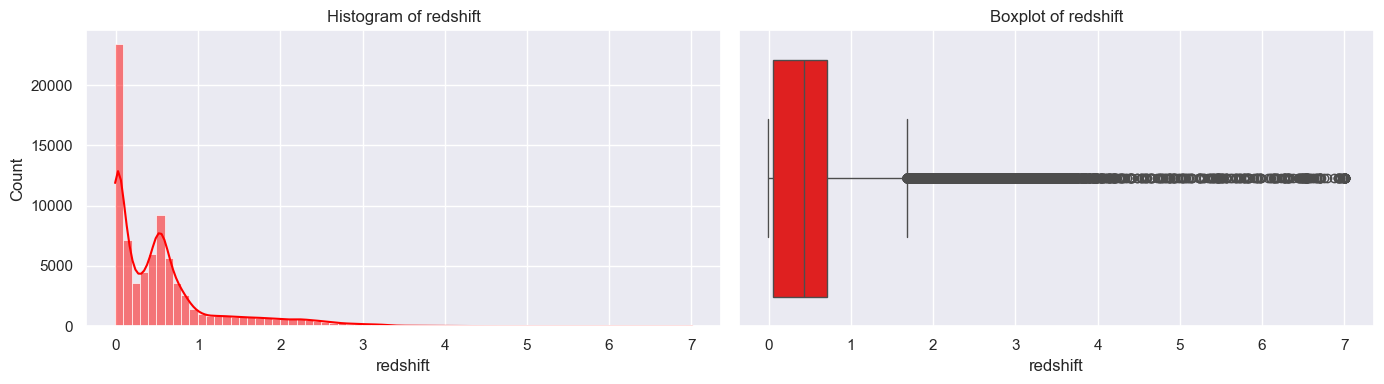

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=eda_train, x="redshift", bins=70, kde=True, ax=axs[0], color="red")
axs[0].set_title("Histogram of redshift")

sns.boxplot(x=eda_train["redshift"], ax=axs[1], color="red")
axs[1].set_title("Boxplot of redshift")

plt.tight_layout()
plt.show()

There is a clear right skewed distribution, with a clear top around 0 and a clear decrease, indicating that most of the objects has very low redshift. There is also a small top at around 0.5-0.8. The boxplot complements the histogram, and shows that there is a lot of outliers with values from 2 and up til 7. 

#### *redshift by class*

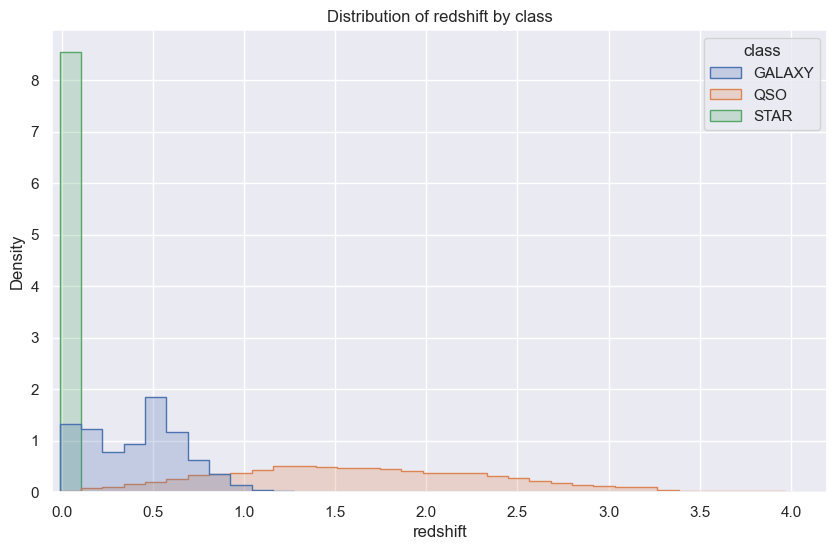

In [15]:
# Redshift per klasse
plt.figure(figsize=(10, 6))
sns.histplot(data=eda_train, x="redshift", hue="class", element="step", stat="density", common_norm=False, bins=60)
plt.xlim(-0.05, 4.2)
plt.title("Distribution of redshift by class")
plt.xlabel("redshift")
plt.ylabel("Density")
plt.show()

- STAR has a narrow distribution around zero, which we also found inthe redshift histogram
- GALAXY has a wider distribution, reaching up til 1. 
- QSO has a long tail and flat distribution going beyond 3.5

### *Correlation Matrix*

/var/folders/bp/p60zkz351mzdr8dqybp1z9t40000gn/T/ipykernel_12306/2003065471.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_all = eda_train.corr()


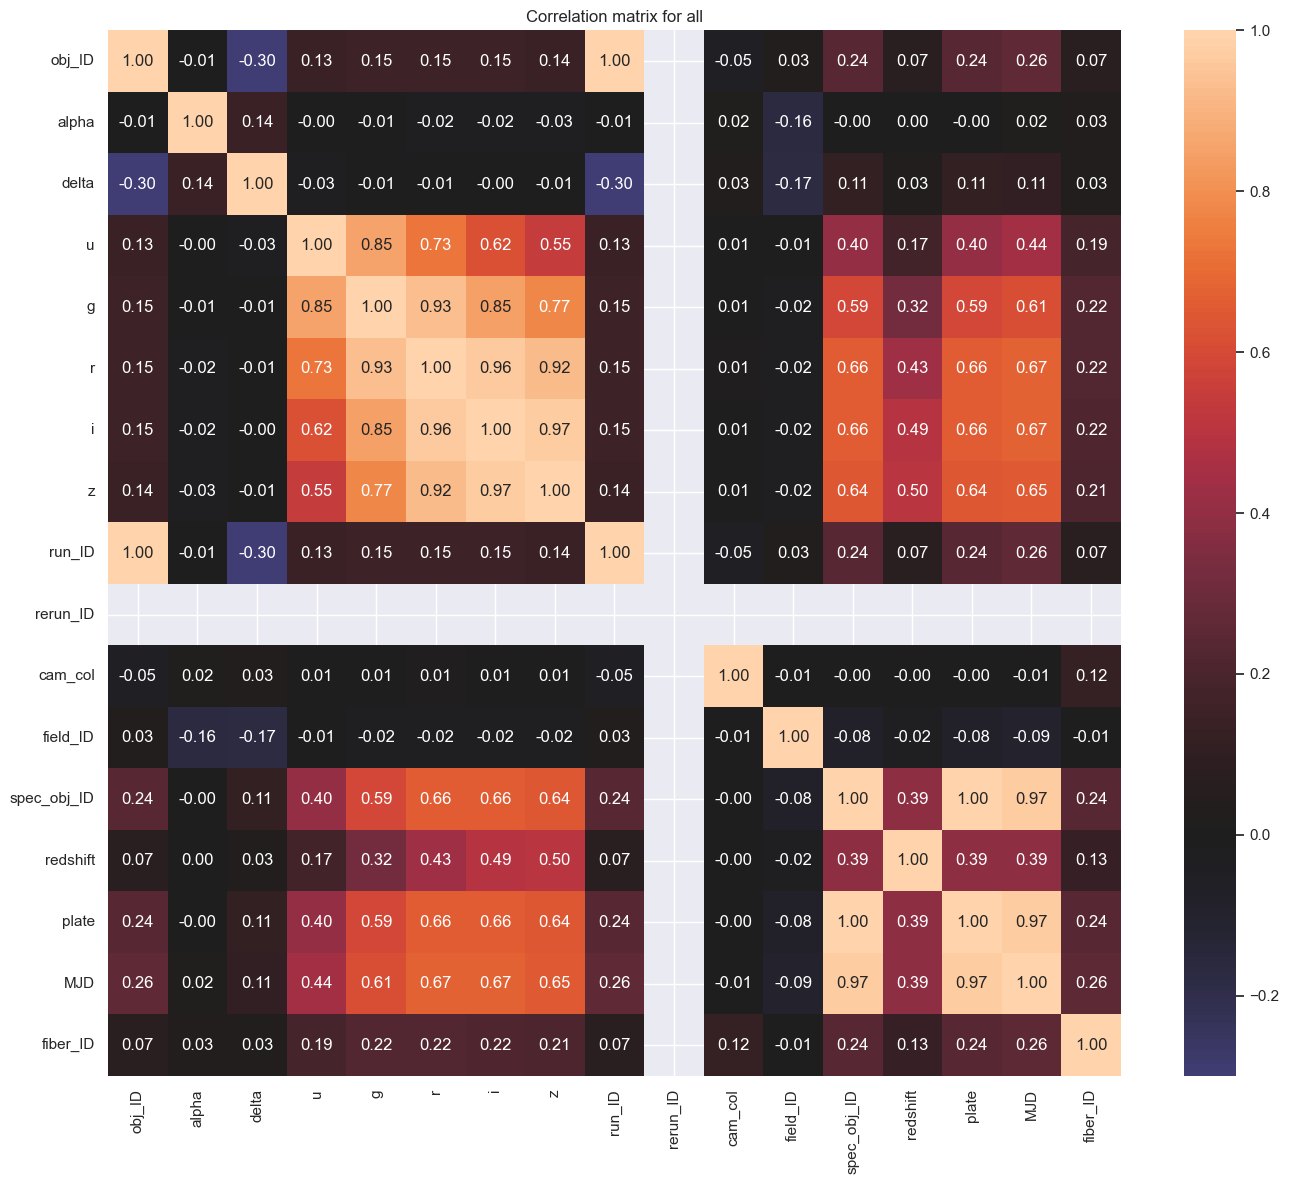

In [16]:
# Correlation Matrix of numerical values
plt.figure(figsize=(14, 12))
corr_all = eda_train.corr()
sns.heatmap(corr_all, annot=True, fmt=".2f", center=0)
plt.title("Correlation matrix for all")
plt.tight_layout()
plt.show()

- There are some highly correlated features - r, i, z, epsecially i-z (0.97) and r-i (0.96), indicating that these filters captures closely related information. 

- redshift has a moderat correlation with the filters, for instance z and redshift has a correlation of 0.5.

- alpha and delta has low correlation with all other features, indicating that these provides low relevant information alone. Could probably remove these in the modelling. 

- Metadata such as obj_ID, spec_obj_ID, fiber_ID and MJD shows low information value, and we can consider to drop these.

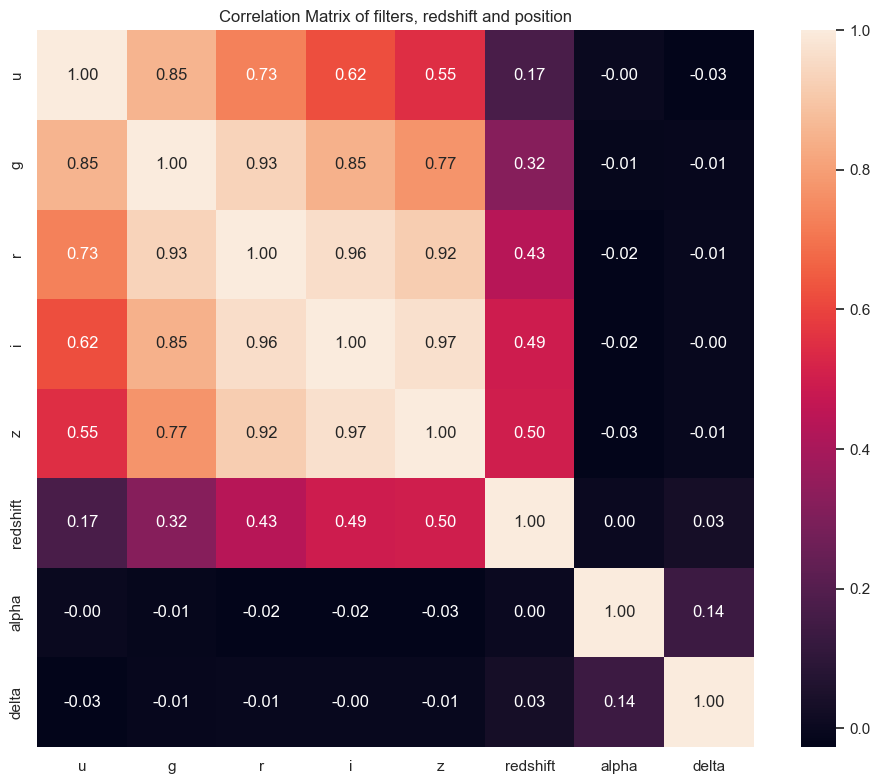

In [17]:
# Gather the numerical features for correlation analysis
corr_cols = ["u", "g", "r", "i", "z", "redshift", "alpha", "delta"]
corr_matrix = eda_train[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", square=True)
plt.title("Correlation Matrix of filters, redshift and position")
plt.tight_layout()

This gives a bit narrower look at the numerical features. No need to elaborate again. 

### *Pairplot of filters and redshift colored by class*

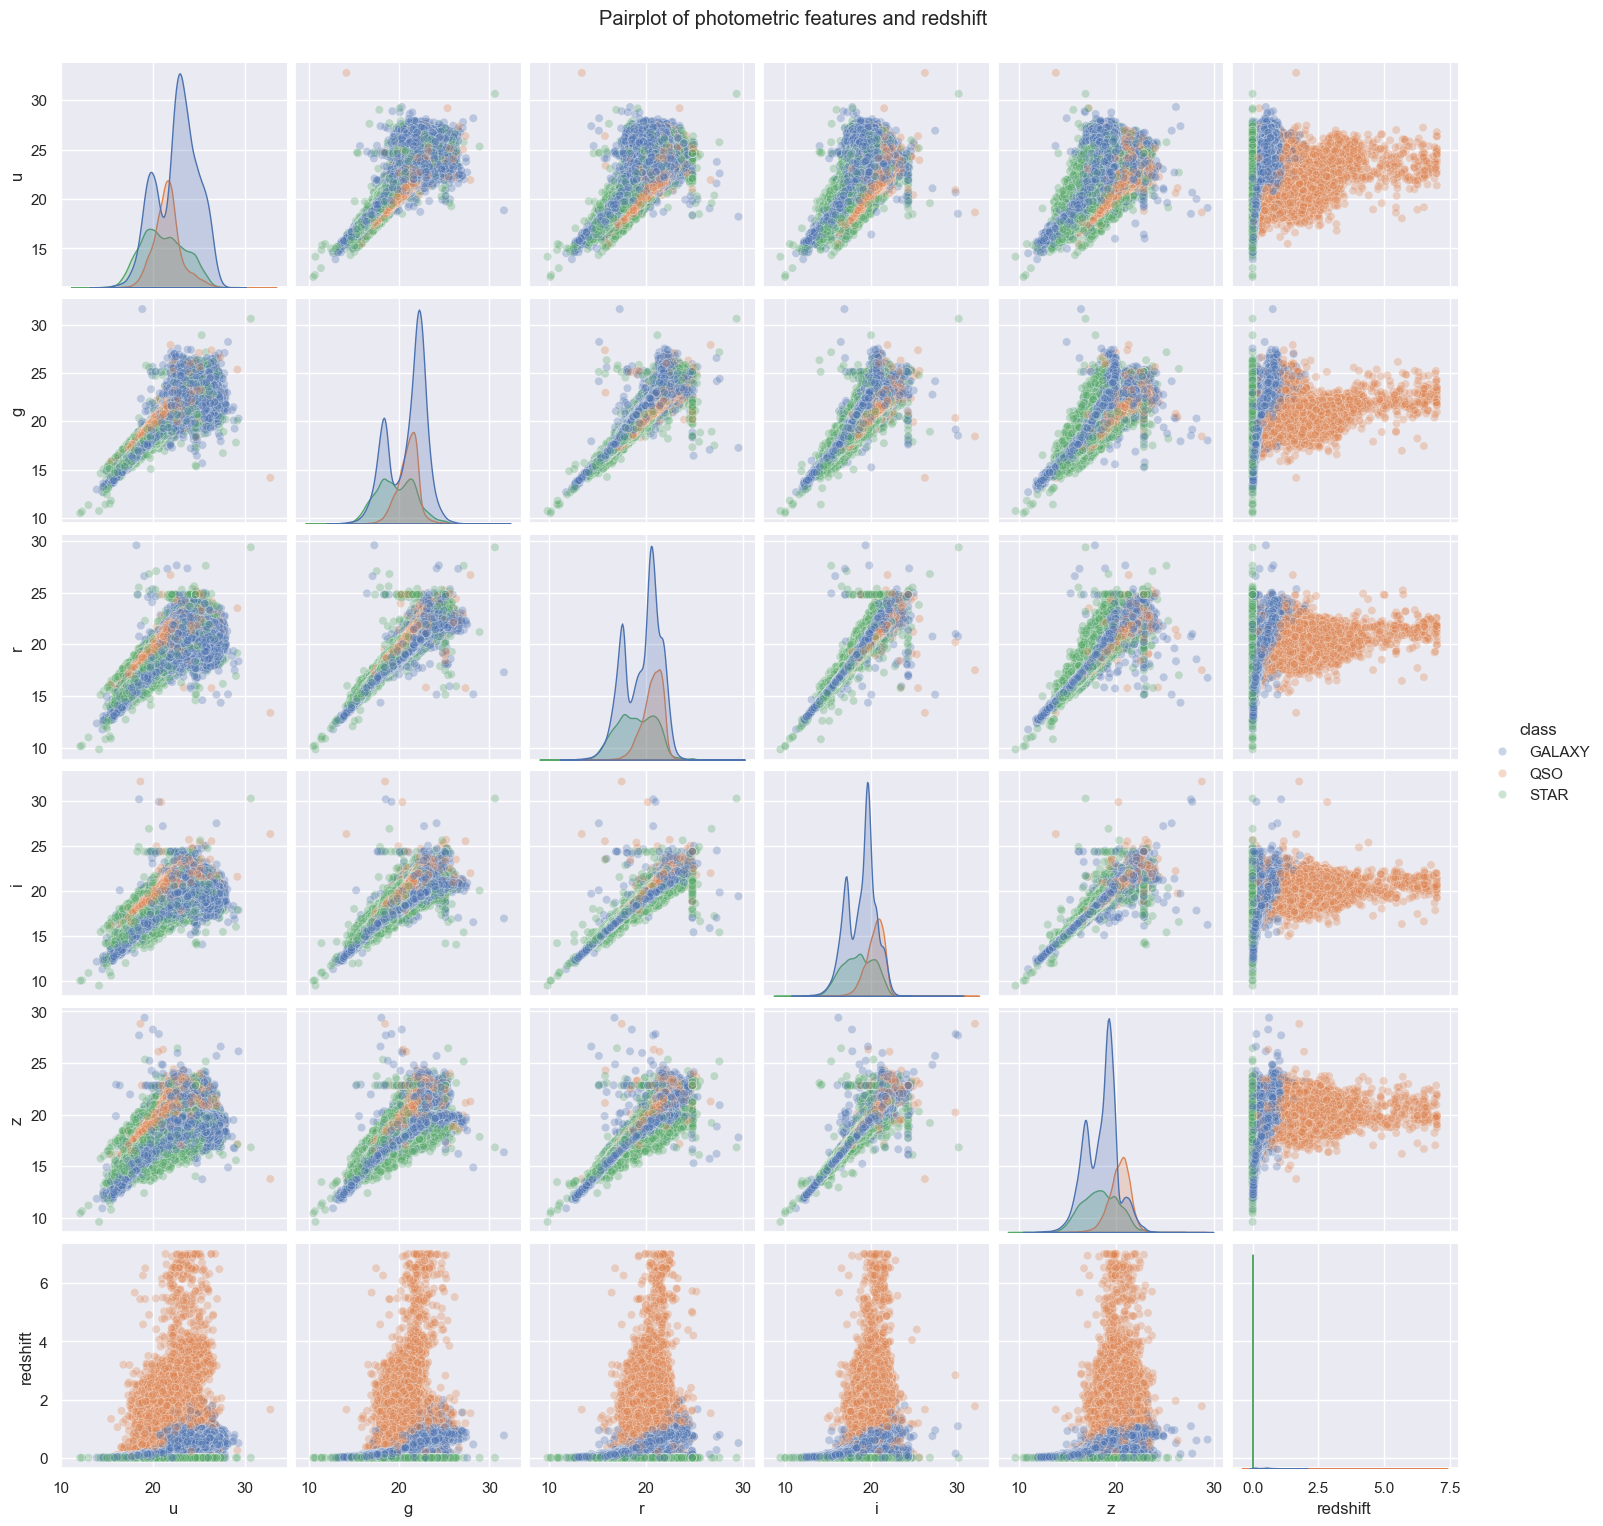

In [18]:
sns.pairplot(eda_train[["u", "g", "r", "i", "z", "redshift", "class"]], hue="class", plot_kws={'alpha': 0.3})
plt.suptitle("Pairplot of photometric features and redshift", y=1.02)
plt.show()

# Can take some time to run

This pairplot shows a lot of what we've already seen, but gives a bit more information as its shows the distribution by the classes. We can see clear patterns between the classes, with a lot of overlaping in most of them. STAR seems to be the most wide spread. Redshift seems to have higher values of th QSO-class. 

### *Other visualizations*

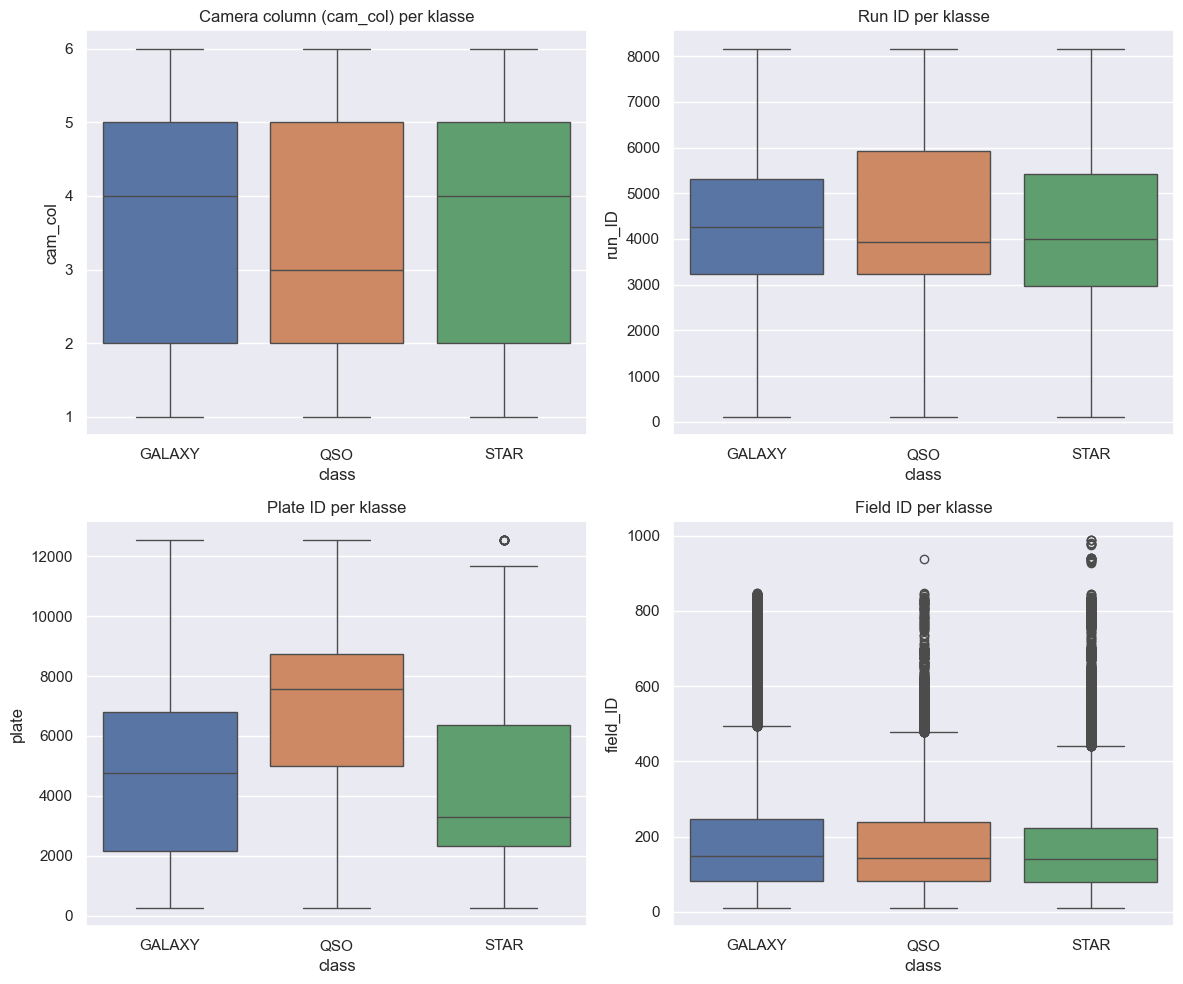

In [19]:
# 2. Se på fordeling av noen metadata-felter per klasse
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x='class', y='cam_col', data=train_df, ax=axs[0, 0], hue= "class")
axs[0, 0].set_title("Camera column (cam_col) per klasse")

sns.boxplot(x='class', y='run_ID', data=train_df, ax=axs[0, 1], hue= "class")
axs[0, 1].set_title("Run ID per klasse")

sns.boxplot(x='class', y='plate', data=train_df, ax=axs[1, 0], hue= "class")
axs[1, 0].set_title("Plate ID per klasse")

sns.boxplot(x='class', y='field_ID', data=train_df, ax=axs[1, 1], hue= "class")
axs[1, 1].set_title("Field ID per klasse")

plt.tight_layout()
plt.show()

The boxplots of the metadata provides further insight into the choice of keeping them or not. 
- cam_col = the distribution is quite identical between the classes, with no clear distinction.
- run_ID = there is variations in the classes, but these are small
- plate = a bit more variation in spread and differences.
- field_ID = quite wide distribution, but no clear distinction between classes. A lot of outliers but we assume that this is more technical than informative.

In [20]:
# Antall unike verdier i metadata
meta_check = ['cam_col', 'field_ID', 'run_ID', 'plate', 'fiber_ID', 'MJD', 'obj_ID', 'spec_obj_ID', "rerun_ID"]
unique_counts = eda_train[meta_check].nunique().sort_values(ascending=False)
print("Unique values in the metadata:")
print(unique_counts)

Unique values in the metadata:
spec_obj_ID    79999
obj_ID         64440
plate           6234
MJD             2176
fiber_ID        1000
field_ID         849
run_ID           426
cam_col            6
rerun_ID           1
dtype: int64


- spec_obj_ID and obj_ID is present in almost all of the objects, and unique. These are just basic identificators so that makes sense.
- rerun_ID is just one value (301), as seen from the descriptive statistics.
- All ofthese are mostly techical values which we assume woun't have that much predictive value 

## **Data cleaning**

In [21]:
# Make a copy 
train_clean = train_df.copy()

### *Extreme Values and Missing Values*

In [22]:
extreme_cols = ["u", "g", "z"]  # Found that -9999 were present in these columns earlier
for col in extreme_cols:
    train_clean[col] = train_clean[col].replace(-9999.0, np.nan)

In [23]:
# Check number of NaNs
train_clean[extreme_cols].isnull().sum()

u    363
g      1
z      1
dtype: int64

The values of -9999 has been successfully imputed as NaNs. So now we have missing values in four of the columns that needs to be dealt with. As this is such a small number compared to the total dataset, we've chosen to remove the rows to avoid adding misinformation from the rows with incorrect values, as well as those with missing values. We are confident that this wouldn't effect the rest of this assignment.

In [24]:
# Remove rows with NaN
initial_len = len(train_clean)
train_clean = train_clean.dropna(subset=extreme_cols)
print(f"# of rows removed because of NaN: {initial_len - len(train_clean)}")    # Double check 

# of rows removed because of NaN: 363


### *Drop features*
As seen from the boxplots, some of the ID-features might be irrelevant for us. We've therefore chosen to remove features because we assume that they woun't provide valuable information to help separate the classes, or that they are just mere technical information.
- obj_ID, spec_obj_ID and fiber_ID are kind of "names" for each observation and we don't think these will make any impact on the classification
- Same with rerun_ID, and this also consist of one single value and no variation
- the metadata describes how or when observations were done, not any characteristics of the objects. The distributions between classes were also similar and didn't give any valuable information.
- alpha and delta are the positions on the sky - showing where we see the observations, but not what we see, and the heatmap indicated that these provides low information. These could also be noise.

In [25]:
# Remove columns that don't seem to have useful information
cols_to_drop = ['obj_ID', 'spec_obj_ID', 'fiber_ID', 'rerun_ID']
for col in cols_to_drop:
    if col in train_clean.columns:
        if train_clean[col].nunique() <= 1 or col in ['obj_ID', 'spec_obj_ID', 'fiber_ID']:
            train_clean.drop(columns=[col], inplace=True)

In [26]:
# Remove other meta data that doesn't seem useful + alpha and delta
meta_cols_to_remove = ['cam_col', 'run_ID', 'field_ID', 'plate', 'MJD', 'alpha', 'delta']
train_clean.drop(columns=meta_cols_to_remove, inplace=True)

In [27]:
# Have a look at the dataset after this
train_clean

,u,g,r,i,z,class,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...
79995,20.96526,19.81625,19.34186,19.14711,19.05790,GALAXY,0.175206
79996,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
79997,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
79998,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366


## *Feature Engineering*
We wanted to try feature engineering on the filters, but chose to do it outside of the pipelines so that we could test models with and without these new variables. 

Here, we combined the original fiters to make filter-change-variable, as well as a log transformed redshift to reduce extreme values as seen in the EDA. 


In [28]:
# Copy to keep clened data in case
train_fe = train_clean.copy()

In [29]:
# New features based on the difference between the filters
train_fe["g_i"] = train_fe["g"] - train_fe["i"]  # green minus near infrared
train_fe["r_z"] = train_fe["r"] - train_fe["z"]  # red minus infrared
train_fe["u_g"] = train_fe["u"] - train_fe["g"]  # ultraviolet minus green

# Log transforming the redshift
train_fe["log_redshift"] = np.log1p(train_fe["redshift"])  # log(1 + redshift)

# check the data
train_fe.head()

,u,g,r,i,z,class,redshift,g_i,r_z,u_g,log_redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,3.10957,1.60130,1.60352,0.491517
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,1.66376,0.97017,1.94571,0.576128
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,3.31532,1.66149,2.59918,0.497251
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,3.27202,2.36152,-1.63974,0.658735
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,1.60317,0.95286,1.85690,0.109861


## **Data preprocessing and visualisation**

### *Label Encoding*

In [30]:
# Make copy - CHOSE TO GO WITH FEATURE ENGINEERING OR NOT
#train_prep = train_clean.copy()   # without FE
train_prep = train_fe.copy()

In [31]:
# Encode target
label_encoder = LabelEncoder()
train_prep["class"] = label_encoder.fit_transform(train_prep["class"])

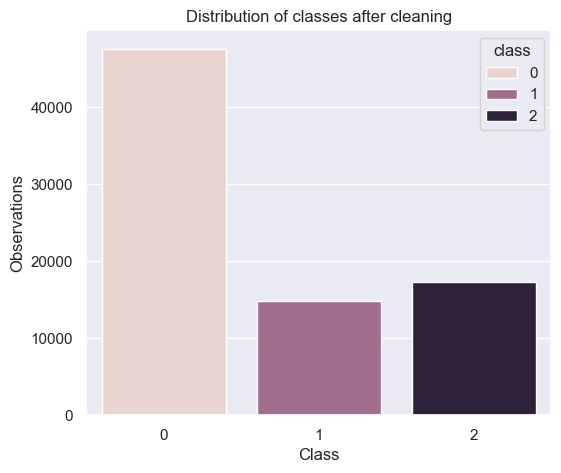

In [32]:
# Visualize to check if the mapping of GALAXY 0, QSO 1, STAR 2 went well
plt.figure(figsize=(6,5))
sns.countplot(x="class", data=train_prep, hue="class")
plt.title("Distribution of classes after cleaning")
plt.xlabel("Class")
plt.ylabel("Observations")
plt.show()

### *Split in X (features) & y (target)*

In [33]:
# Split into features and target
X = train_prep.drop(columns=["class"])  # Features
y = train_prep["class"]                 # Target

In [34]:
# Define feature types
numerical_features = [col for col in X.columns if col not in ["class"]]  # All the features are numerical now
categorical_features = []  # We've already removed the categorical features

In [35]:
# Define the preprocessor pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features)
    # No need for OneHotEncoder as the categorical features is removed
])

In [36]:
# Get overview of how it looks now
print(f"Shape of dataset: {X.shape}")                                       
print(f"Features used: {numerical_features}")
print("Distribution of the classes:\n", y.value_counts(normalize=True))

Shape of dataset: (79637, 10)
Features used: ['u', 'g', 'r', 'i', 'z', 'redshift', 'g_i', 'r_z', 'u_g', 'log_redshift']
Distribution of the classes:
 0    0.597524
2    0.216608
1    0.185868
Name: class, dtype: float64


## **Evaluating Models & Hyperparameters**

In [37]:
# Defining class labels for reports and plots
class_names = ["GALAXY", "QSO", "STAR"]

In [38]:
# Split the data in 60/40
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

### *Pipeline 1: SVC + PCA*

In [39]:
pipe_svc = Pipeline([
    ('preprocess', preprocessor),               
    ('pca', PCA()),                             # Dimensionality reduction
    ('svc', SVC(kernel='rbf'))                  # Classificator
])

# Parameter distributions for RandomizedSearchCV
param_dist_svc = {
    'pca__n_components': [6, 8, 10],     # PCA components to test - we only have 10 features in our data
    'svc__C': loguniform(0.1, 80),       # Regularizationparameter C
    'svc__gamma': loguniform(0.001, 1)    # Gamma
}

# RandomizedSearchCV for SVC with F1 macro and 5-fold CV
random_search_svc = RandomizedSearchCV(
    pipe_svc,
    param_distributions=param_dist_svc,
    n_iter=15,                              # Number of combination
    cv=5,                                   # 5-fold Cross validation
    scoring='f1_macro',                     
    n_jobs=-1,
    random_state=42,
    verbose=2
)


random_search_svc.fit(X_train, y_train)         # Run hyperparametertuning on training
svc_best = random_search_svc.best_estimator_    # Get best model from search
svc_best                                        # Show pipeline

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV] END pca__n_components=6, svc__C=5.403930031501208, svc__gamma=0.02175195311877764; total time=   7.8s
[CV] END pca__n_components=6, svc__C=5.403930031501208, svc__gamma=0.02175195311877764; total time=   8.2s
[CV] END pca__n_components=6, svc__C=5.403930031501208, svc__gamma=0.02175195311877764; total time=   8.1s
[CV] END pca__n_components=10, svc__C=20.532222852774808, svc__gamma=0.003550621427070771; total time=  10.0s
[CV] END pca__n_components=10, svc__C=20.532222852774808, svc__gamma=0.003550621427070771; total time=   9.9s
[CV] END pca__n_components=10, svc__C=20.532222852774808, svc__gamma=0.003550621427070771; total time=  10.3s
[CV] END pca__n_components=10, svc__C=20.532222852774808, svc__gamma=0.003550621427070771; total time=  10.4s
[CV] END pca__n_components=10, svc__C=20.532222852774808, svc__gamma=0.003550621427070771; total time=  10.6s
[CV] END pca__n_components=6, svc__C=5.403930031501208, svc__gamma=0.02175195311877764; total time=   7.5s
[CV] END pca__n_compon

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['u', 'g', 'r', 'i', 'z',
                                                   'redshift', 'g_i', 'r_z',
                                                   'u_g', 'log_redshift'])])),
                ('pca', PCA(n_components=6)),
                ('svc', SVC(C=63.57943823664366, gamma=0.2661901888489056))])

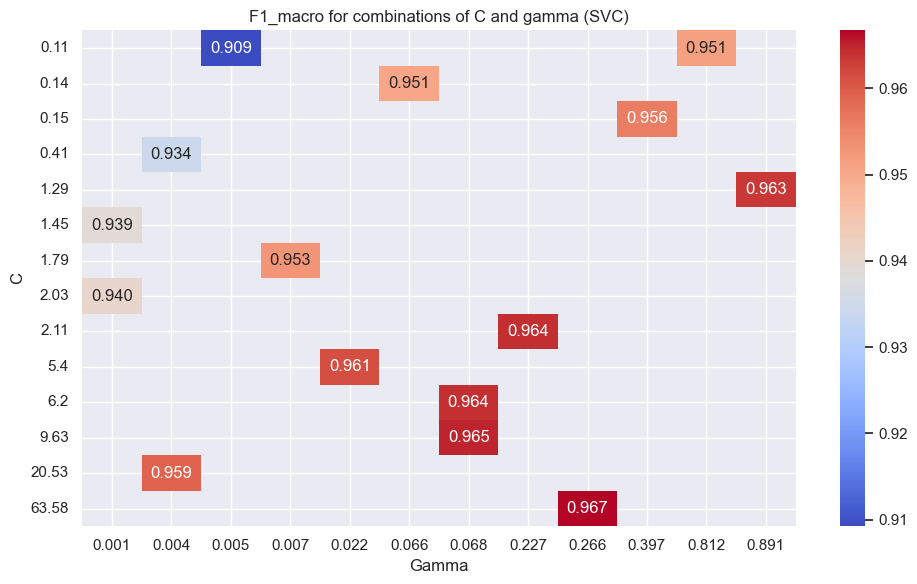

In [40]:
# Visualization
# Make df with results from randomizedsearch
svc_results = pd.DataFrame(random_search_svc.cv_results_)

# Make pivottable with C and gamma
svc_results["C"] = svc_results["param_svc__C"].astype(float).round(2)
svc_results["gamma"] = svc_results["param_svc__gamma"].astype(float).round(3)

# pivottable for heatmap
heatmap_data = svc_results.pivot_table(
    index="C", columns="gamma", values="mean_test_score"
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("F1_macro for combinations of C and gamma (SVC)")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()

This heatmap indicates that the modell performes with high C and somewhat moderat gamma, for instance C = 63.58 and gamma = 0.266 has a F1 score of 0.967.

In [41]:
# Evaluate SVC on testset
# Predictions and F1 score
y_pred_svc = svc_best.predict(X_test)
f1_macro_svc = f1_score(y_test, y_pred_svc, average='macro')
print(f"\n SVC (RBF) - Macro F1-score: {f1_macro_svc:.4f}")

# Make report with precision, recall and F1 score per class
print(" ========== Classification Report (SVC) ==========")
print(classification_report(y_test, y_pred_svc, target_names=class_names))


 SVC (RBF) - Macro F1-score: 0.9694
 ========== Classification Report (SVC) ==========
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     19034
         QSO       0.97      0.93      0.95      5921
        STAR       0.97      1.00      0.98      6900

    accuracy                           0.97     31855
   macro avg       0.97      0.97      0.97     31855
weighted avg       0.97      0.97      0.97     31855



Quite good F1 score at 0.9694. The classes are treated equally, and scores high, especially STAR and GALAXY. 

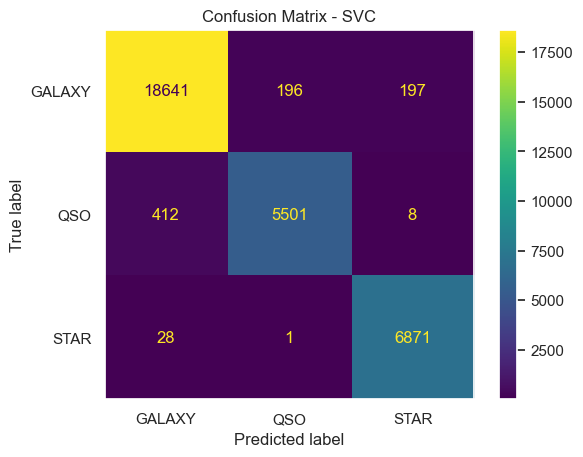

In [42]:
# Confusion matrix for SVC pipeline
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_svc,
    display_labels=class_names
)
plt.title("Confusion Matrix - SVC")
plt.grid(False)
plt.show()

As seen from the report, GALAXY has high precision and recall, thus low failurerate. QSO is confused with GALAXY quite a few times, 412 to be exact, which will have a impact of the recall (0.93). 

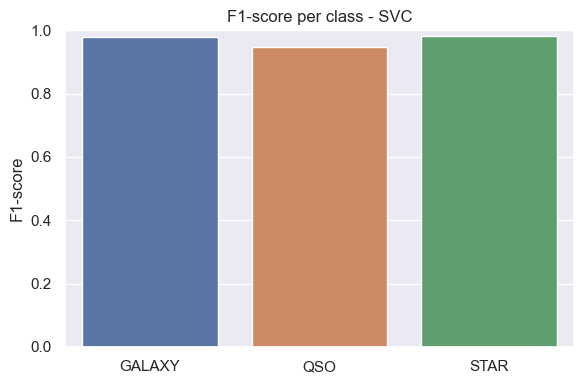

In [43]:
# Barplot for F1 score per class
report_svc = classification_report(y_test, y_pred_svc, target_names=class_names, output_dict=True)
f1_scores_svc = [report_svc[c]["f1-score"] for c in class_names]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=f1_scores_svc, hue = class_names)
plt.ylim(0, 1)
plt.title("F1-score per class - SVC")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

All of the classes has high scores, with STAR having the highest and QSO the lowest. 

According to all of these outputs, QSO seems to be more challenging than the two others.

### *Pipeline 2: Logistic Regression + PCA*

In [44]:
# Setup - Logistic Regression and PCA
pipe_lr = Pipeline([
    ('preprocess', preprocessor),                                   
    ('pca', PCA()),                                                 # Dimensionality reduction
    ('lr', LogisticRegression(solver='lbfgs', max_iter=2000))       # lbfgs instead of liblinear to deal with the big dataset   (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
])

# Define hyperparameters
param_dist_lr = {
    'pca__n_components': [6, 8, 10],       # PCA components to test
    'lr__C': loguniform(0.1, 500),         # Strength of regularization
    'lr__penalty': ['l2']                   # Using L2 regularization
}

# Randomized hyperparameter search, using 5-fold crossvaldiation and evaluating with F1 macro score
random_search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    n_iter=25,                          # Combinatiosn to test randomly
    cv=5,                               # 5-fold Cross validation
    scoring='f1_macro',                 # Using F1 macro to weight all classes equally
    n_jobs=-1,          
    random_state=42,
    verbose=1
)

random_search_lr.fit(X_train, y_train)          # Run hyperparametertuning on training
lr_best = random_search_lr.best_estimator_      # Get best model from search
lr_best                                         # Show pipeline 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['u', 'g', 'r', 'i', 'z',
                                                   'redshift', 'g_i', 'r_z',
                                                   'u_g', 'log_redshift'])])),
                ('pca', PCA(n_components=8)),
                ('lr',
                 LogisticRegression(C=373.11604524743126, max_iter=2000))])

In [45]:
# Evaluation
# Predictions and F1 score
y_pred_lr = lr_best.predict(X_test)
f1_macro_lr = f1_score(y_test, y_pred_lr, average='macro')
print(f"Logistic Regression - Macro F1-score: {f1_macro_lr:.4f}")

# Report with precision, recall and F1 score per class
print(" ========== Classification Report (LogReg) ========== ")
print(classification_report(y_test, y_pred_lr, target_names=class_names))

Logistic Regression - Macro F1-score: 0.9587
 ========== Classification Report (LogReg) ========== 
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     19034
         QSO       0.95      0.89      0.92      5921
        STAR       0.97      1.00      0.99      6900

    accuracy                           0.96     31855
   macro avg       0.96      0.95      0.96     31855
weighted avg       0.96      0.96      0.96     31855



The macro F1-score for Logistic Regression is also quite high, but a bit lower than the SVC. QSO has a much lower recall-value than the SVC - 0.89 vs. 0.93, which might be the reason for the lower F1 score compared to SVC. 

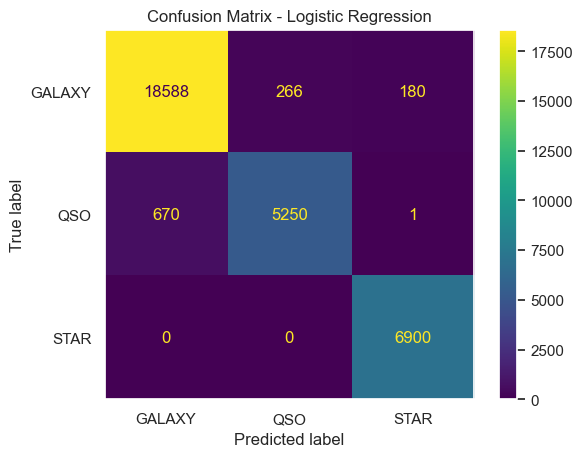

In [46]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=class_names
)
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

GALAXY and STAR has low failurerate, while QSO still has some issues with GALAXY with 670 wrong classifications. STAR seems to be classified perfectly.

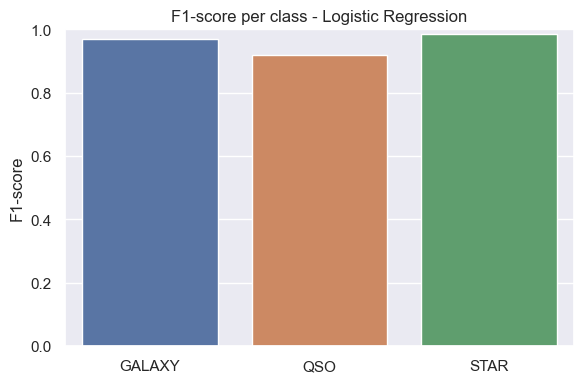

In [47]:
# Visualization of F1 score per class
report_lr = classification_report(y_test, y_pred_lr, target_names=class_names, output_dict=True)
f1_scores_lr = [report_lr[c]["f1-score"] for c in class_names]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=f1_scores_lr, hue = class_names)
plt.ylim(0, 1)
plt.title("F1-score per class - Logistic Regression")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

Same as fo the SVC - STAR has the highest, QSO the lowest, probably because of the low recall.

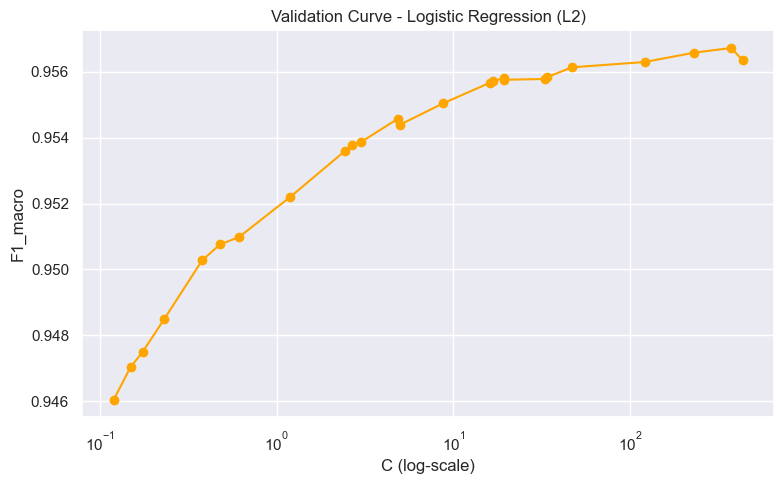

In [48]:
# Gather search results and sort by C
results_lr = pd.DataFrame(random_search_lr.cv_results_)
results_lr_sorted = results_lr.sort_values(by="param_lr__C")

# Plot validation curve for C
plt.figure(figsize=(8, 5))
plt.plot(
    results_lr_sorted["param_lr__C"], 
    results_lr_sorted["mean_test_score"], 
    marker='o', linestyle='-', color='orange'
)
plt.xscale('log')           # Log-scale for better visualization
plt.xlabel("C (log-scale)")
plt.ylabel("F1_macro")
plt.title("Validation Curve - Logistic Regression (L2)")
plt.tight_layout()
plt.show()

The higher the C, the higher the F1 score. At one point the curve seems to converge.

### *Pipeline 3: Random forest*

In [49]:
pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))     # Random Forest classifier
])

# Define hyperparameters
param_dist_rf = {
    'rf__n_estimators': [100, 200, 300],            # # of trees
    'rf__max_depth': [None, 10, 20, 30],            # Depth per tree
    'rf__min_samples_split': [2, 5, 10]             # Min amount of samples for split
}

# Randomsearch with 5-fold and f1 macro score
random_search_rf = RandomizedSearchCV(
    pipe_rf, param_dist_rf, n_iter=10, cv=5,
    scoring='f1_macro', n_jobs=-1, verbose=1, random_state=42
)


random_search_rf.fit(X_train, y_train)          # Train model on trainset
rf_best = random_search_rf.best_estimator_      # Get best model
rf_best

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['u', 'g', 'r', 'i', 'z',
                                                   'redshift', 'g_i', 'r_z',
                                                   'u_g', 'log_redshift'])])),
                ('rf',
                 RandomForestClassifier(max_depth=30, min_samples_split=10,
                                        n_estimators=300, random_state=42))])

In [50]:
# Evaluation - predictions and F1 score
y_pred_rf = rf_best.predict(X_test)
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"\n Random Forest - Macro F1-score: {f1_macro_rf:.4f}")

# Make report
print(" ========== Classification Report (Random Forest) ========== ")
print(classification_report(y_test, y_pred_rf, target_names=class_names))


 Random Forest - Macro F1-score: 0.9773
 ========== Classification Report (Random Forest) ========== 
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     19034
         QSO       0.97      0.93      0.95      5921
        STAR       1.00      1.00      1.00      6900

    accuracy                           0.98     31855
   macro avg       0.98      0.97      0.98     31855
weighted avg       0.98      0.98      0.98     31855



The Random Forest model has the highest F1-score so far, of 0.9773. Recall for QSO is now better than LogReg (0.89) and same as the SVC (0.92). STAR has a perfect precision and recall of 1, while GALAXY also scores high.

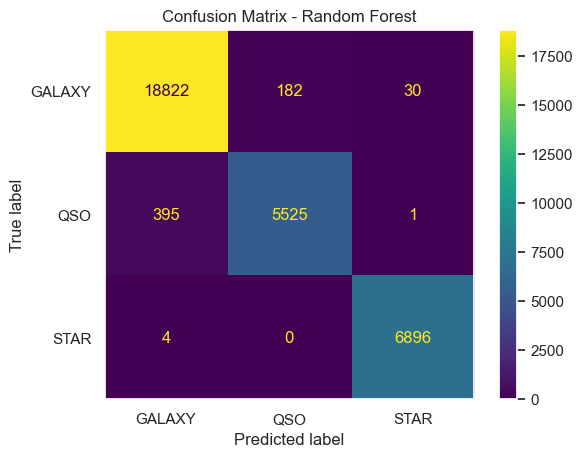

In [51]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=class_names
)
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

GALAXY and STAR is almost perfecly classified. QSO is still misclassified as GALAXY, but with a lower amount than the other models. 

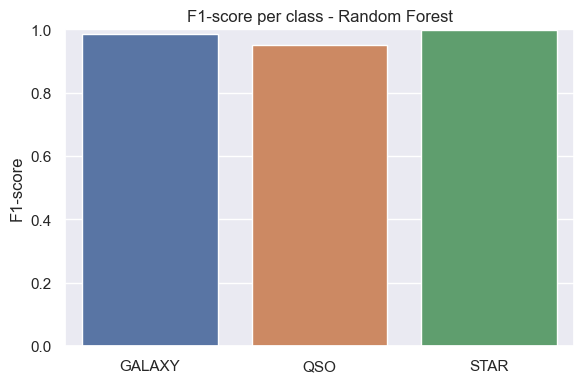

In [52]:
# Barplot for F1 score per class
report_rf = classification_report(y_test, y_pred_rf, target_names=class_names, output_dict=True)
f1_scores_rf = [report_rf[c]["f1-score"] for c in class_names]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=f1_scores_rf, hue = class_names)
plt.ylim(0, 1)
plt.title("F1-score per class - Random Forest")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

### *Pipeline 4: KNN*

In [53]:
pipe_knn = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Hyperparameter definining
param_dist_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],               # # of neighbours
    'knn__weights': ['uniform', 'distance']         # Distance / equal weight
}

# Randomized search with F1 macro and cv5
random_search_knn = RandomizedSearchCV(             
    pipe_knn, param_dist_knn, n_iter=8, cv=5,
    scoring='f1_macro', n_jobs=-1, verbose=1, random_state=42
)

# Train and find best model
random_search_knn.fit(X_train, y_train)
knn_best = random_search_knn.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [54]:
# Evaluation - predictions and F1 score
y_pred_knn = knn_best.predict(X_test)
f1_macro_knn = f1_score(y_test, y_pred_knn, average='macro')
print(f"\n KNN - Macro F1-score: {f1_macro_knn:.4f}")

# Report
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=class_names))


 KNN - Macro F1-score: 0.9603
Classification Report (KNN):
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     19034
         QSO       0.97      0.93      0.95      5921
        STAR       0.94      0.99      0.96      6900

    accuracy                           0.96     31855
   macro avg       0.96      0.96      0.96     31855
weighted avg       0.97      0.96      0.96     31855



A bit lower than the SVC, but higher than LogReg. QSO is again the loser, and STAR also performes a bit lower compared to the other. 

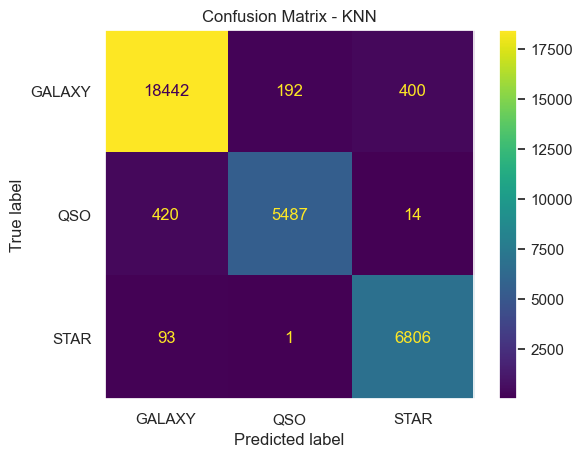

In [55]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn,
    display_labels=class_names,
)
plt.title("Confusion Matrix - KNN")
plt.grid(False)
plt.show()

There is a bit more misclassifications in this model than the others, but still less than LogReg.

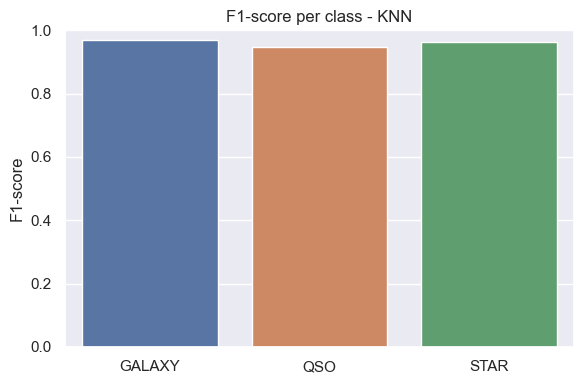

In [56]:
# Visualization of F1 score per class
report_knn = classification_report(y_test, y_pred_knn, target_names=class_names, output_dict=True)
f1_scores_knn = [report_knn[c]["f1-score"] for c in class_names]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=f1_scores_knn, hue= class_names)
plt.ylim(0, 1)
plt.title("F1-score per class - KNN")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

### *Comparisons*

In [57]:
# Gather all F1 scores for all models
f1_scores = {
    "SVC (RBF)": f1_macro_svc,
    "Logistic Regression": f1_macro_lr,
    "Random Forest": f1_macro_rf,
    "KNN": f1_macro_knn
}

# Print comparison
print("\n Comparison of test F1_macro:")
for model_name, score in f1_scores.items():
    print(f"{model_name:20}: {score:.4f}")


 Comparison of test F1_macro:
SVC (RBF)           : 0.9694
Logistic Regression : 0.9587
Random Forest       : 0.9773
KNN                 : 0.9603


/var/folders/bp/p60zkz351mzdr8dqybp1z9t40000gn/T/ipykernel_12306/3955733078.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Set1")


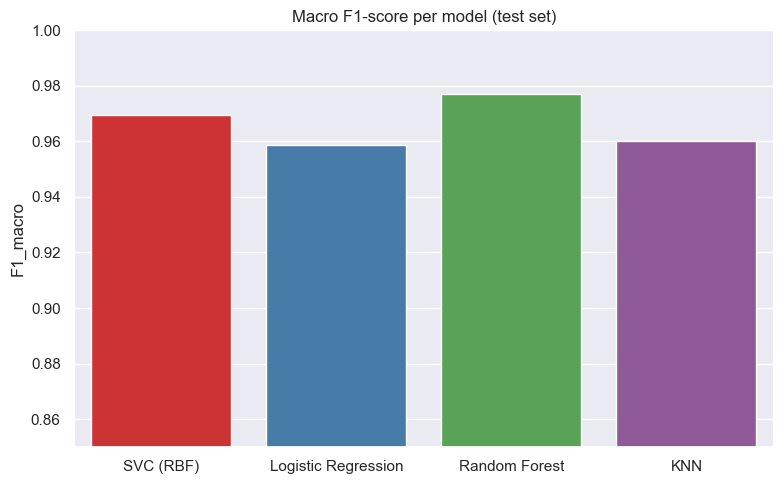

In [58]:
# Visualization of F1 score per model
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Set1")
plt.ylim(0.85, 1.00)
plt.title("Macro F1-score per model (test set)")
plt.ylabel("F1_macro")
plt.tight_layout()
plt.show()

As seen from the walkthrough of the models, Random Forest is the one scoring the highest of the ones we have tried, with a score of 0.9773. This will therefore be the one we'll test on Kaggle.

## **Final**

In [59]:
# Clean test data - remove columns as in train
cols_to_remove = ["obj_ID", "spec_obj_ID", "fiber_ID", "rerun_ID"]
test_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')

# Remove metadata
meta_cols_to_remove = ['cam_col', 'run_ID', 'field_ID', 'plate', 'MJD', 'alpha', 'delta']
test_df.drop(columns=meta_cols_to_remove, inplace=True, errors='ignore')

In [60]:
# Feature engineering – same as done for training data
test_df["g_i"] = test_df["g"] - test_df["i"]
test_df["r_z"] = test_df["r"] - test_df["z"]
test_df["u_g"] = test_df["u"] - test_df["g"]
test_df["log_redshift"] = np.log1p(test_df["redshift"])

In [61]:
# Predictions with the best model (i.e. Random Forest)
y_test_pred = rf_best.predict(test_df)

In [62]:
# Make submission file for Kaggle
submission_kaggle = pd.DataFrame({
    "ID": test_df.index,
    "class": y_test_pred
})

# Double check shape
print(submission_kaggle.head())
print(submission_kaggle.shape)  # Must be 20 000 & 2

   ID  class
0   0      0
1   1      2
2   2      2
3   3      2
4   4      2
(20000, 2)


In [63]:
submission_kaggle.to_csv("kaggle_CA4_5.csv", index=False)